In [ ]:
!nvidia-smi

Fri Jul 14 05:01:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   1171MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import glob
# Importing drive method from colab for accessing google drive
from google.colab import drive
# Mounting drive
# This will require authentication : Follow the steps as guided
drive.mount('/Data')

Drive already mounted at /Data; to attempt to forcibly remount, call drive.mount("/Data", force_remount=True).


In [ ]:
!ls /Data/'My Drive'/dataset

 cifar-10-batches-py   cifar-10-python.tar.gz  'LeGO-LOAM Public Dataset'


In [ ]:
!pip install gradio
import gradio as gr

In [ ]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

#resize功能
from scipy import misc
from PIL import Image

# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR

num_classes = 10
# 超参数设置
num_epochs = 100
batch_size = 5
learning_rate = 0.001

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

In [ ]:
LOAD_CIFAR = True
DOWNLOAD_CIFAR = False
# 从data继承读取数据集的类
from torch.utils.data import Dataset, DataLoader

# 训练数据集
train_data = torchvision.datasets.CIFAR10(
    root='/Data/My Drive/dataset',
    train=True,
    transform=transform,
    download=DOWNLOAD_CIFAR,
)

# 测试数据集
test_data = torchvision.datasets.CIFAR10(
    root='/Data/My Drive/dataset',
    train=False,
    transform=transform
)

In [ ]:
# 训练数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
# 测试数据加载器
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

ship


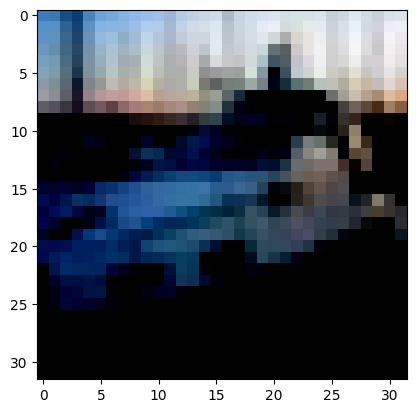

In [ ]:
# 查看数据,取一组batch
data_iter = iter(test_loader)

images, labels = next(data_iter)
# 取batch中的一张图像
idx = 2
image = images[idx].numpy()
image = np.transpose(image, (1,2,0))
plt.imshow(image)
print(classes[labels[idx].numpy()])

In [ ]:
# 搭建卷积神经网络模型
# 三个卷积层
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
            # 32*32*3
        self.conv1 = nn.Sequential(
            # 卷积层计算
            nn.Conv2d(3, 5, kernel_size=5, stride=1, padding=2),
            #  批归一化
            nn.BatchNorm2d(5),
            #ReLU激活函数
            nn.ReLU(),
            # 池化层：最大池化
            nn.MaxPool2d(kernel_size=2, stride=1))
            # 31*31*5

        self.conv2 = nn.Sequential(
            nn.Conv2d(5, 8, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))# 搭建卷积神经网络模型
            # 30*30*8

        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))# 搭建卷积神经网络模型
            # 15*15*16

        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))# 搭建卷积神经网络模型
            # 14*14*24

        self.conv5 = nn.Sequential(
            nn.Conv2d(24, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))# 搭建卷积神经网络模型
            # 7*7*32

        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(7*7*32, 400),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, num_classes),
        )

    # 定义前向传播顺序
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# 实例化一个模型
model = ConvNet(num_classes)

In [ ]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 自动调整学习率
#scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

In [ ]:
# 设置cuda-gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi

cuda:0
Fri Jul 14 05:01:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   1171MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [ ]:
# 开始训练
model = model.cuda()
# 存储损失与精度
loss_history = []
accuracy_history = []
loss_times_history = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):

        images = images.cuda()
        labels = labels.cuda()
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #累计损失
        running_loss += loss.item()
        loss_times_history.append(loss.item())
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i+1) % 1000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    #scheduler.step()
    #计算各epoch中的平均损失值和准确率
    avg_loss = running_loss / len(train_loader)
    accuracy = 100.0 * correct_train / total_train
    #存储平均损失值和准确率
    loss_history.append(avg_loss)
    accuracy_history.append(accuracy)
    #输出学习率
    #print(f"Epoch [{epoch+1}/{num_epochs}], Learning Rate: {scheduler.get_lr()[0]}")

Epoch [1/100], Step [1000/10000], Loss: 1.3494
Epoch [1/100], Step [2000/10000], Loss: 1.3223
Epoch [1/100], Step [3000/10000], Loss: 1.3823
Epoch [1/100], Step [4000/10000], Loss: 1.5643
Epoch [1/100], Step [5000/10000], Loss: 1.2320
Epoch [1/100], Step [6000/10000], Loss: 1.1237
Epoch [1/100], Step [7000/10000], Loss: 1.3282
Epoch [1/100], Step [8000/10000], Loss: 2.0840
Epoch [1/100], Step [9000/10000], Loss: 1.7427
Epoch [1/100], Step [10000/10000], Loss: 1.4063
Epoch [2/100], Step [1000/10000], Loss: 1.5620
Epoch [2/100], Step [2000/10000], Loss: 2.1181
Epoch [2/100], Step [3000/10000], Loss: 1.1890
Epoch [2/100], Step [4000/10000], Loss: 1.5455
Epoch [2/100], Step [5000/10000], Loss: 1.3084
Epoch [2/100], Step [6000/10000], Loss: 1.5834
Epoch [2/100], Step [7000/10000], Loss: 0.8817
Epoch [2/100], Step [8000/10000], Loss: 1.1666
Epoch [2/100], Step [9000/10000], Loss: 1.9252
Epoch [2/100], Step [10000/10000], Loss: 1.5154
Epoch [3/100], Step [1000/10000], Loss: 1.5563
Epoch [3/10

In [ ]:
# 输出测试集精度
#总精度及各类精度相关参数定义
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print('Accuracy of the net on the train iamges is {:.2f} %'.format(accuracy_history[-1]))
print('Accuracy of the net on the test iamges is {:.2f} %'.format(100 * correct / total))
print('\n')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the net on the train iamges is 76.37 %
Accuracy of the net on the test iamges is 69.11 %


Accuracy for class: plane is 71.6 %
Accuracy for class: car   is 82.4 %
Accuracy for class: bird  is 53.1 %
Accuracy for class: cat   is 56.5 %
Accuracy for class: deer  is 65.6 %
Accuracy for class: dog   is 58.7 %
Accuracy for class: frog  is 74.5 %
Accuracy for class: horse is 72.6 %
Accuracy for class: ship  is 74.4 %
Accuracy for class: truck is 81.7 %


In [ ]:
#  保存模型
torch.save(model.state_dict(), 'model.ckpt')

In [ ]:
# 可视化数据查看
import itertools
def print_label(input_dex):
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(range(num_epochs), loss_history)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Curve')

  plt.subplot(1, 2, 2)
  plt.plot(range(num_epochs), accuracy_history)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curve')

  curve_fig = "curve.png"
  plt.savefig(curve_fig)
  curve = Image.open(curve_fig)
  k = int(int(input_dex)/batch_size)
  m = int(int(input_dex)%batch_size)
  data_iter = iter(test_loader)
  images, labels = next(itertools.islice(data_iter, k, k+1))
  image = images[m].numpy()
  image = np.transpose(image, (1,2,0))
  show_img = image
  imagebatch = image.reshape(-1,3,32,32)
  # 转换为torch tensor
  image_tensor = torch.from_numpy(imagebatch)
  image_tensor = image_tensor.cuda()
  # 调用模型进行评估
  model.eval()
  output = model(image_tensor)
  precise, predicted = torch.max(output.data, 1)
  pre = predicted.cpu().numpy()

  return curve,classes[pre[0]],classes[labels[m].numpy()],show_img


demo = gr.Interface(fn=print_label,
                    inputs=gr.Textbox(label="Input 0-9999"),
                    outputs=[gr.outputs.Image(type="pil",label="loss and acc"),
                    gr.Textbox(label="predict label"),
                    gr.Textbox(label="true label"),
                    gr.outputs.Image(type="pil",label="Image")]
                    )
demo.launch()


<ipython-input-35-0ae37dc151c8>:42: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=[gr.outputs.Image(type="pil",label="loss and acc"),
<ipython-input-35-0ae37dc151c8>:45: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  gr.outputs.Image(type="pil",label="Image")]


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>